# side model feature selection

In [2]:
import pandas as pd

df_features = pd.read_parquet("data/features_45m.parquet")
df_features.shape

(59138, 11841)

In [9]:
import numpy as np
from jesse import utils

label = np.load("data/label_dollar_bar_45m.npy")
df_label = utils.numpy_candles_to_dataframe(label[:, :6]).set_index("date")
df_label["side_label"] = label[:, 6]
df_label.head(1)

,open,close,high,low,volume,side_label
date,,,,,,
2020-01-01 01:22:00,7188.72,7185.59,7260.43,7174.0,52620.421,-1.0


In [21]:
side_features = df_features.iloc[538:]
side_label = df_label.iloc[538:]

side_label["side_label"] = (side_label["side_label"].astype(int) == 1).astype(int)
side_label = side_label["side_label"].to_numpy()

print(side_features.shape)
print(side_label.shape)

side_features.isna().sum(axis=0).sort_values(ascending=False)

/var/folders/2g/md1t2j7s6hjdjc5jlvkmn7_c0000gn/T/ipykernel_30092/1267099876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  side_label["side_label"] = (side_label["side_label"].astype(int) == 1).astype(int)


(58600, 11841)
(58600,)


10m_ac_0                    0
4h_ac_4                     0
45m_williams_r_ddt_lag35    0
45m_williams_r_ddt_lag36    0
45m_williams_r_ddt_lag37    0
                           ..
45m_ac_2                    0
45m_ac_3                    0
45m_ac_4                    0
45m_ac_5                    0
4h_williams_r_ddt_lag39     0
Length: 11841, dtype: int64

In [22]:
# meta feature selection
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=side_features.shape[1] // 2,
    scoring="f1",
    cv=5,
    regression=False,
    n_jobs=-1,
)
sel.fit(side_features, side_label)

MRMR(cv=5, max_features=5920, method='FCQ', n_jobs=-1, scoring='f1')

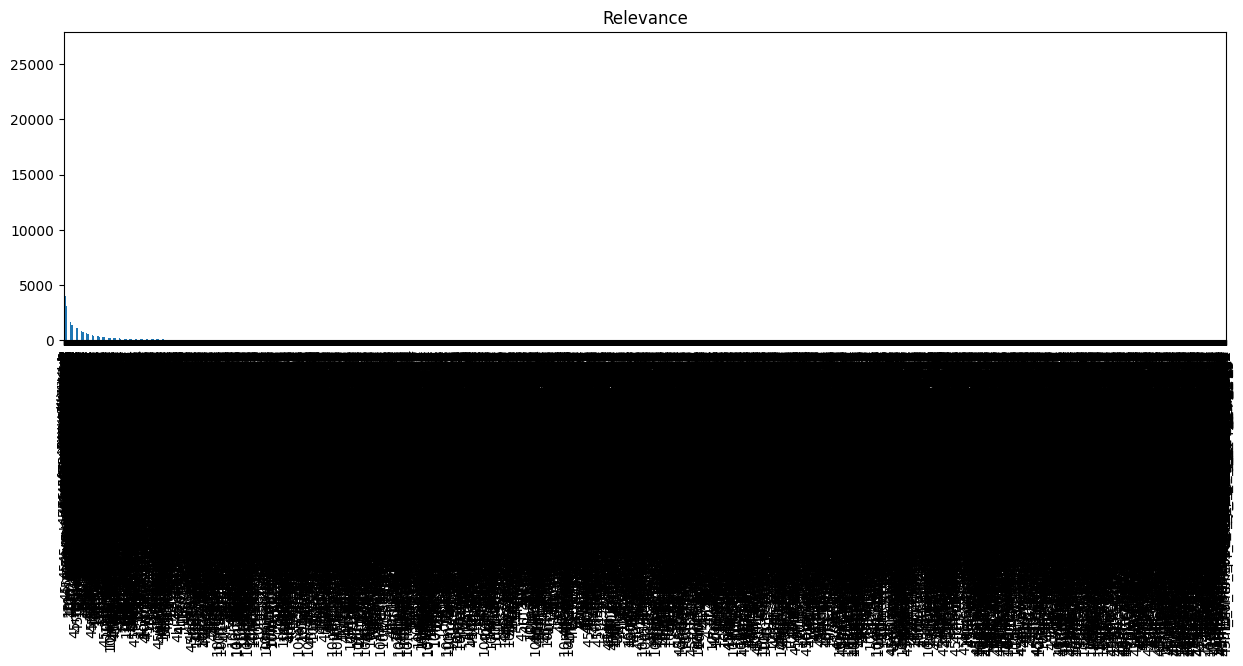

In [23]:
import matplotlib.pyplot as plt

pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False).plot.bar(
    figsize=(15, 4)
)
plt.title("Relevance")
plt.show()

In [24]:
side_res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False)
side_res

45m_williams_r                           2.661149e+04
45m_acc_swing_index_dt                   1.815520e+04
45m_trendflex_dt                         1.295715e+04
45m_fisher_dt                            1.252252e+04
45m_williams_r_dt                        9.464486e+03
                                             ...     
45m_natr_ddt_lag39                       6.312325e-07
45m_pfe_ddt_lag20                        5.660231e-07
45m_dual_diff_lag30                      4.359391e-07
4h_vwap_ddt_lag7                         2.336137e-07
45m_comb_spectrum_dom_cycle_ddt_lag31    1.422279e-08
Length: 11841, dtype: float64

In [25]:
len([k for k, v in side_res.to_dict().items() if v > 1])

8007

In [1]:
import json

with open("data/mrmr_side_features.json", "w") as f:
    json.dump(side_res.to_dict(), f)

NameError: name 'side_res' is not defined

In [3]:
import json
import pandas as pd

with open("data/mrmr_side_features.json", "r") as f:
    side_res = pd.Series(json.load(f))

In [4]:
SHORT_TERM = "10m"
MEDIUM_TERM = "45m"
LONG_TERM = "4h"

feature_info = {
    "all": [],
    "side": {SHORT_TERM: [], MEDIUM_TERM: [], LONG_TERM: []},
    "meta": {SHORT_TERM: [], MEDIUM_TERM: [], LONG_TERM: [], "model_res": []},
}

for k, v in side_res.to_dict().items():
    if v > 10:
        if k.startswith(f"{SHORT_TERM}_"):
            feature_info["side"][SHORT_TERM].append(k)
            feature_info["all"].append(k.replace(f"{SHORT_TERM}_", ""))
        elif k.startswith(f"{MEDIUM_TERM}_"):
            feature_info["side"][MEDIUM_TERM].append(k)
            feature_info["all"].append(k.replace(f"{MEDIUM_TERM}_", ""))
        elif k.startswith(f"{LONG_TERM}_"):
            feature_info["side"][LONG_TERM].append(k)
            feature_info["all"].append(k.replace(f"{LONG_TERM}_", ""))

feature_info["all"] = sorted(list(set(feature_info["all"])))
feature_info["side"][SHORT_TERM] = sorted(list(set(feature_info["side"][SHORT_TERM])))
feature_info["side"][MEDIUM_TERM] = sorted(list(set(feature_info["side"][MEDIUM_TERM])))
feature_info["side"][LONG_TERM] = sorted(list(set(feature_info["side"][LONG_TERM])))

feature_info["meta"][SHORT_TERM] = sorted(list(set(feature_info["meta"][SHORT_TERM])))
feature_info["meta"][MEDIUM_TERM] = sorted(list(set(feature_info["meta"][MEDIUM_TERM])))
feature_info["meta"][LONG_TERM] = sorted(list(set(feature_info["meta"][LONG_TERM])))
feature_info["meta"]["model_res"] = sorted(list(set(feature_info["meta"]["model_res"])))

with open("custom_indicators/feature_info.json", "w") as f:
    json.dump(feature_info, f)

# meta model feature selection

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from custom_indicators.config import SIDE_ALL

df_features = pd.read_parquet("data/features_45m.parquet")
df_label = pd.read_parquet("data/label_meta_45m.parquet")

model_side = lgb.Booster(model_file="custom_indicators/models/model_side.txt")
model_side_res = model_side.predict(df_features[SIDE_ALL])
df_features["model_side_res"] = model_side_res
print(df_features.shape)

assert df_features.shape[0] == df_label.shape[0]
print(df_label.shape)
df_label.head()

(59137, 11842)
(59137, 9)


,open,high,low,close,volume,ret,trgt,bin,side
index,,,,,,,,,
2020-01-01 01:22:00+00:00,7188.72,7260.43,7174.00,7185.59,52620.421,NaN,NaN,0.0,0.0
2020-01-01 23:31:00+00:00,7185.59,7209.59,7101.00,7107.40,53122.462,NaN,NaN,0.0,0.0
2020-01-02 13:51:00+00:00,7107.67,7154.06,6922.00,6960.29,54102.611,NaN,NaN,0.0,0.0
2020-01-02 20:22:00+00:00,6960.73,7300.00,6863.44,7239.60,54169.888,NaN,NaN,0.0,0.0
2020-01-03 04:45:00+00:00,7239.54,7333.00,7148.14,7294.00,53029.463,NaN,NaN,0.0,0.0


In [3]:
meta_features = df_features[583:]
meta_label = df_label["bin"][583:]

# meta_features = meta_features[meta_label["ret"].notna()]
# meta_label = meta_label[meta_label["ret"].notna()]["bin"]

print(meta_features.shape)
print(meta_label.shape)

(58554, 11842)
(58554,)


In [4]:
# meta feature selection
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=meta_features.shape[1] // 2,
    scoring="f1",
    cv=3,
    regression=False,
    n_jobs=-1,
)
sel.fit(meta_features, meta_label)

KeyboardInterrupt: 

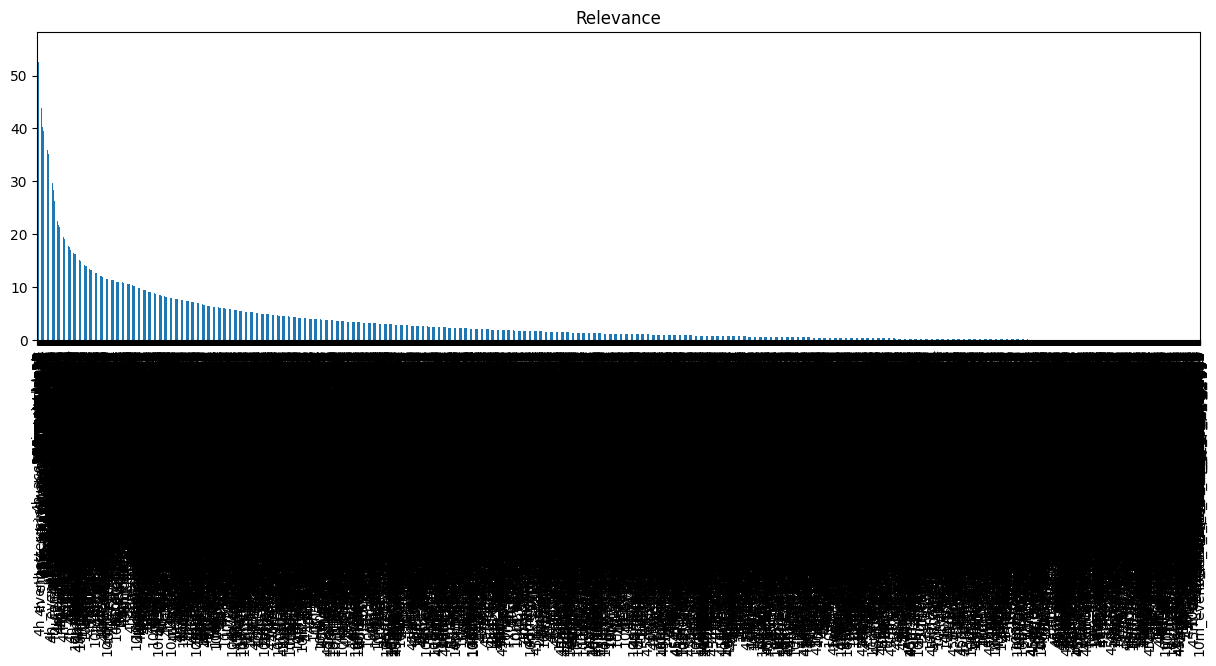

In [ ]:
import matplotlib.pyplot as plt

pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False).plot.bar(
    figsize=(15, 4)
)
plt.title("Relevance")
plt.show()

In [6]:
meta_res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False)
meta_res

10m_natr_lag28            5.548226e+01
10m_natr_lag26            5.533051e+01
10m_natr_lag27            5.507478e+01
10m_natr_lag29            5.416361e+01
4h_acc_swing_index_dt     5.400103e+01
                              ...     
45m_fisher_lag18          1.528230e-06
4h_vwap_lag32             9.567177e-07
45m_vwap_dt_lag6          2.469889e-07
10m_natr_dt_lag7          2.342767e-07
10m_homodyne_ddt_lag31    1.027183e-08
Length: 11842, dtype: float64

In [7]:
import json

with open("data/mrmr_meta_features.json", "w") as f:
    json.dump(meta_res.to_dict(), f)

In [15]:
meta_res.to_dict()["model_side_res"]

11.580109396592349

In [18]:
len([k for k, v in meta_res.to_dict().items() if v > 1])

1027

In [19]:
from pathlib import Path

feature_info = Path("custom_indicators/feature_info.json")
if feature_info.exists():
    with open(feature_info, "r") as f:
        feature_info = json.load(f)

SHORT_TERM = "3m"
MEDIUM_TERM = "15m"
LONG_TERM = "1h"

for k, v in meta_res.to_dict().items():
    if v > 1:
        if k.startswith(f"{SHORT_TERM}_"):
            feature_info["meta"][SHORT_TERM].append(k)
            feature_info["all"].append(k.replace(f"{SHORT_TERM}_", ""))
        elif k.startswith(f"{MEDIUM_TERM}_"):
            feature_info["meta"][MEDIUM_TERM].append(k)
            feature_info["all"].append(k.replace(f"{MEDIUM_TERM}_", ""))
        elif k.startswith(f"{LONG_TERM}_"):
            feature_info["meta"][LONG_TERM].append(k)
            feature_info["all"].append(k.replace(f"{LONG_TERM}_", ""))
        else:
            feature_info["meta"]["model_res"].append(k)

feature_info["all"] = sorted(list(set(feature_info["all"])))
feature_info["side"][SHORT_TERM] = sorted(list(set(feature_info["side"][SHORT_TERM])))
feature_info["side"][MEDIUM_TERM] = sorted(list(set(feature_info["side"][MEDIUM_TERM])))
feature_info["side"][LONG_TERM] = sorted(list(set(feature_info["side"][LONG_TERM])))

feature_info["meta"][SHORT_TERM] = sorted(list(set(feature_info["meta"][SHORT_TERM])))
feature_info["meta"][MEDIUM_TERM] = sorted(list(set(feature_info["meta"][MEDIUM_TERM])))
feature_info["meta"][LONG_TERM] = sorted(list(set(feature_info["meta"][LONG_TERM])))
feature_info["meta"]["model_res"] = sorted(list(set(feature_info["meta"]["model_res"])))

with open("custom_indicators/feature_info.json", "w") as f:
    json.dump(feature_info, f)